In [1]:
%load_ext autoreload
%autoreload 2

# Glow
**Article**: [Kingma et. al., 2018](https://arxiv.org/pdf/1807.03039.pdf)
**Credits**: 

The code is based on the following: [github](https://github.com/rosinality/glow-pytorch)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Tdata
import torchvision as TV
import torchvision.transforms as TVtrf
import torchvision.utils as TVutils
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    FULL_DEVICE = 'cuda:{}'.format(GPU_DEVICE)
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# TODO: adapt for colab users
# DGM utils
import sys
import os
# sys.path.append('../../homeworks')
# from dgm_utils import train_model, plot_training_curves, show_samples
# from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

## Data loading

`CelebA` dataset

In [3]:
class PictureDataset(Tdata.Dataset):
    def __init__(self, folder, split_type="Train", transform=None):
        super(PictureDataset).__init__()
        self.transform = transform
        self.folder = folder
        # It's more comfortable this way
        split_idx = ["train", "val", "test"].index(split_type.lower())
        df = pd.read_csv(f"{folder}/list_eval_partition.csv")
        # We load the images to memory from the start
        self.img_ids = df[df['partition'] == split_idx]['image_id'].values
#         self.images = []
#         for img_id in tqdm(img_ids):
#             img = Image.open(f"{folder}/img_align_celeba/img_align_celeba/{img_id}").convert('RGB')
#             self.images.append(img)
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img = Image.open(f"{self.folder}/img_align_celeba/{img_id}").convert('RGB')
        # img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
transform = TVtrf.Compose([
        TVtrf.CenterCrop(140),
        TVtrf.Resize((64, 64)),
        TVtrf.ToTensor()
        # TVtrf.Normalize((.5, .5, .5), (.5, .5, .5))
    ])


# read Celeba from local disk
# train_celeba = TV.datasets.ImageFolder(root='./datasets/celeba/train/', transform=transform)
# test_celeba = TV.datasets.ImageFolder(root='./datasets/celeba/test/', transform=transform)

# or download from kaggle api
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jessicali9530/celeba-dataset
# !unzip celeba-dataset.zip -d ./datasets/celeba
# !rm celeba-dataset.zip

train_celeba = PictureDataset("datasets/celeba", split_type="train", transform=transform)
test_celeba = PictureDataset("datasets/celeba", split_type="val", transform=transform)

# train_celeba = TV.datasets.CelebA(root='./datasets/celeba/img_align_celeba/img_align_celeba/', split='train', download=False, transform=transform)
# test_celeba = TV.datasets.CelebA(root='./datasets/celeba/img_align_celeba/img_align_celeba/', split='test', download=False, transform=transform)

train_loader = Tdata.DataLoader(train_celeba, batch_size=256, shuffle=True)
test_loader = Tdata.DataLoader(test_celeba, batch_size=256, shuffle=False)

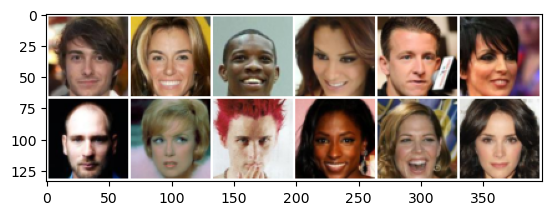

In [6]:
grid = TVtrf.functional.to_pil_image(TVutils.make_grid(next(iter(train_loader))[:12], nrow=6, normalize=True, pad_value=1.))
plt.imshow(grid)

### Utilities

In [7]:
def logabs(x):
    return torch.log(torch.abs(x))

# Glow components


## ActNorm class


In [10]:
class ActNorm(nn.Module):

    def __init__(self, in_channel, logdet=True):
        super().__init__()

        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet


    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))


    def forward(self, input):
        _, _, height, width = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        log_abs = logabs(self.scale)

        logdet = height * width * torch.sum(log_abs)

        if self.logdet:
            return self.scale * (input + self.loc), logdet

        else:
            return self.scale * (input + self.loc)

    def reverse(self, output):
        return output / self.scale - self.loc

## Invertible `1x1` convolution


**Reducing `logdet` computation cost by LU decomposition**:

In [11]:
# implementation without (P)LU decomposition

class InvConv2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight) # generates random orthogonal matrix
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)

    def forward(self, input):
        _, _, height, width = input.shape

        out = F.conv2d(input, self.weight)
        logdet = (
            height * width * torch.slogdet(self.weight.squeeze().double())[1].float()
        )

        return out, logdet

    def reverse(self, output):
        return F.conv2d(
            output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        )

# implementation with (P)LU decomposition
from scipy import linalg as la

class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T

        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)

        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)

    def forward(self, input):
        _, _, height, width = input.shape

        weight = self.calc_weight()

        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)

        return out, logdet

    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )

        return weight.unsqueeze(2).unsqueeze(3)

    def reverse(self, output):
        weight = self.calc_weight()

        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))

In [12]:
# in_channel = 2
# weight = np.random.randn(in_channel, in_channel)
# q, _ = la.qr(weight)
# print(q)
# w_p, w_l, w_u = la.lu(q.astype(np.float32))
# print('P:\n', w_p)
# print('L:\n', w_l)
# print('U with diags:\n', w_u)
# w_s = np.diag(w_u)
# w_u = np.triu(w_u, 1)
# u_mask = np.triu(np.ones_like(w_u), 1)
# l_mask = u_mask.T

# w_p = torch.from_numpy(w_p)
# w_l = torch.from_numpy(w_l)
# w_s = torch.from_numpy(w_s)
# w_u = torch.from_numpy(w_u)

## ZeroConv2D


In [13]:
class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out

## AffineCoupling

Uses `ChannelCoupling` scheme from **RealNVP**:


In [160]:
class AffineCoupling(nn.Module):

    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()

        self.affine = affine

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )

        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()

        self.net[2].weight.data.normal_(0, 0.05)
        self.net[2].bias.data.zero_()

    def forward(self, input):
        in_a, in_b = input.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(in_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s
            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)

        else:
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None

        return torch.cat([in_a, out_b], 1), logdet

    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(out_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t

        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out

        return torch.cat([out_a, in_b], 1)

9468896


## One step of Glow 

In [218]:
def count_parameters(model):
    total_param = 0
    for i in model.parameters():
        total_param += np.prod(i.shape)
    return total_param

class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True, layers_mask=[1, 1, 1]):
        '''
        Layer_mask indicates which parts of the flow model should be turned on, and which are not
        '''
        super().__init__()
        self.mask = layers_mask
        if self.mask[0]:
            self.actnorm = ActNorm(in_channel)
            print('actnorm parameter count:', count_parameters(self.actnorm))
        if self.mask[1]:
            if conv_lu:
                self.invconv = InvConv2dLU(in_channel)
            else:
                self.invconv = InvConv2d(in_channel)
            print('invconv parameter count:', count_parameters(self.invconv))
        if self.mask[2]:
            self.coupling = AffineCoupling(in_channel, affine=affine)
            print('coupling parameter count:', count_parameters(self.coupling))

    def forward(self, input):
        # Fallback in case we turn everything off -_-
        logdet = torch.ones(input.shape[0], device=input.device)
        out = input
        if self.mask[0]:
            out, det = self.actnorm(out)
            logdet += det
        if self.mask[1]:
            out, det1 = self.invconv(out)
            logdet = logdet + det1
        if self.mask[2]:
            out, det2 = self.coupling(out)
            if det2 is not None:
                logdet = logdet + det2
        return out, logdet

    def reverse(self, output):
        input = output
        if self.mask[2]:
            input = self.coupling.reverse(input)
        if self.mask[1]:
            input = self.invconv.reverse(input)
        if self.mask[0]:
            input = self.actnorm.reverse(input)

        return input


## Multi-scale architercture of NF 

At each step, half the variables are directly modeled as Gaussians, while the other half undergo further transformation.:


In [219]:
def gaussian_log_p(x, mean, log_sd):
    return -0.5 * np.log(2 * np.pi) - log_sd - 0.5 * ((x - mean) ** 2) / torch.exp(2 * log_sd)


def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps

## Glow one-scale block

Recall the `squeeze`/`unsqueeze` operator from `RealNVP`


In [220]:
class Block(nn.Module):

    def __init__(self, in_channel, n_flow, split=True, 
                 affine=True, conv_lu=True, layers_mask=[1, 1, 1]):
        super().__init__()

        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, 
                                   conv_lu=conv_lu, layers_mask=layers_mask))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)

        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)

    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        # Squeeze operation
        squeezed = input.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det

        if self.split:
            # out will be transformed further, z_new will be modelled as gaussian
            out, z_new = out.chunk(2, 1) 
            
            # data-dependent prior
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)

        else:
            # dummy initialization of data-dependent prior (i.e. it becomes data-independent)
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out

        return out, logdet, log_p, z_new

    def reverse(self, output, eps=None, reconstruct=False):
        '''
        reconstruct: weather output sampled from data-dependent prior or from standard gaussian
        '''
        input = output

        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)
            else:
                input = eps
        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z

        for flow in self.flows[::-1]:
            input = flow.reverse(input)

        b_size, n_channel, height, width = input.shape
        
        # Unsqueeze operation
        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed

# Combining the above togeter: Glow model


In [221]:
from math import log, pi, exp

class Glow(nn.Module):
    
    def __init__(
        self, in_channel, n_flow, n_block, 
        affine=True, conv_lu=True, layers_mask=[1, 1, 1]
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, 
                                     conv_lu=conv_lu, layers_mask=layers_mask))
            n_channel *= 2 # why does we multiply by 2, not 4?
        self.blocks.append(Block(n_channel, n_flow, split=False, 
                                 affine=affine, layers_mask=layers_mask))

    def forward(self, input):
        log_p_sum = 0
        logdet = 0
        out = input
        z_outs = []

        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det

            if log_p is not None:
                log_p_sum = log_p_sum + log_p

        return log_p_sum, logdet, z_outs

    def loss(self, input, image_size=64, n_bins=8):
        log_p, logdet, _ = self.forward(input)
        n_pixel = image_size * image_size * 3
        assert log_p.shape == (input.size(0),)
        assert logdet.shape == (input.size(0),)
        # print(input.shape, log_p[:5], logdet[:5], n_pixel)
        loss_val = -log(n_bins) * n_pixel
        loss_val = loss_val + logdet + log_p

        return {
            "nll_loss": (-loss_val / (log(2) * n_pixel)).mean(), 
            "logP": (log_p / (log(2) * n_pixel)).mean(),
            "logdet": (logdet / (log(2) * n_pixel)).mean()
            }

    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)

            else:
                input = block.reverse(input, z_list[-(i + 1)], reconstruct=reconstruct)

        return input

### Training

In [222]:
def calc_z_shapes(n_channel, input_size, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2 # note mul by 2, not 4

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes

In [223]:
def train(args, model, optimizer, train_loader, loss_key="nll_loss", model_prefix=""):
    
    n_bins = 2.0 ** args.n_bits
    
    z_sample = []
    z_shapes = calc_z_shapes(3, args.img_size, args.n_block)
    
    for z in z_shapes:
        z_new = torch.randn(args.n_sample, *z) * args.temp
        z_sample.append(z_new.to(DEVICE))
    
    forrange = tqdm(range(args.epochs))
    i = 0
    history = {'Loss': [],
               'logP': [],
               'logdet': []}
    for epoch in forrange:
        run_losses = {'Loss': [],
                      'logP': [],
                      'logdet': []}
        for image in train_loader:
            image = image.to(DEVICE)

            # image preprocessing
            image = image * 255

            if args.n_bits < 8:
                image = torch.floor(image / 2 ** (8 - args.n_bits))

            image = image / n_bins - 0.5
            
            # note uniform dequantization
            losses = model.loss(image + torch.rand_like(image) / n_bins)
            
            model.zero_grad()
            losses[loss_key].backward()
            optimizer.step()
            loss, log_p, log_det = losses['nll_loss'].item(), losses['logP'].item(), losses['logdet'].item()

            forrange.set_description(
                f"Loss: {loss:.5f}; logP: {log_p:.5f}; logdet: {log_det:.5f};"
            )
            run_losses['Loss'].append(loss)
            run_losses['logP'].append(log_p)
            run_losses['logdet'].append(log_det)

            if i % 100 == 0:
                with torch.no_grad():
                    os.makedirs('./sample', exist_ok=True)
                    TVutils.save_image(
                        model.reverse(z_sample).cpu().data,
                        f"sample/{str(i + 1).zfill(6)}_{model_prefix}.png",
                        normalize=True,
                        nrow=10,
                        #range=(-0.5, 0.5),
                    )
            i += 1
        history['Loss'].append(np.mean(run_losses['Loss']))
        history['logP'].append(np.mean(run_losses['logP']))
        history['logdet'].append(np.mean(run_losses['logdet']))
    return history

In [224]:
class Config():
    pass

CONFIG = Config()

CONFIG.img_size = 64
CONFIG.batch_size = 256
CONFIG.epochs = 10
CONFIG.n_block = 4 # number of blocks with different resolution
CONFIG.n_flow = 4 # number of flows in each block
CONFIG.no_lu = False
CONFIG.affine = True
CONFIG.n_bits = 5
CONFIG.lr = 1e-4
CONFIG.temp = 0.7 # temperature of sampling (lower temperature reduces the number of outliers)
CONFIG.n_sample = 20

In [225]:
def make_model(CONFIG):
    model = Glow(
        3, CONFIG.n_flow, CONFIG.n_block, affine=CONFIG.affine, conv_lu=not CONFIG.no_lu, layers_mask=CONFIG.layers_mask
    )
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.lr)
    return model, optimizer

In [226]:
import json

def save_all(model, optim, CONFIG, losses, folder="checkpoints", model_prefix=""):
    checkpoint = {
        'model': model.cpu().state_dict(),
        'optimizer': optimizer.state_dict()}
#     os.mkdir(folder)
    torch.save(checkpoint, f'{folder}/checkpoint_{model_prefix}.pth')
    features = [name for name in dir(CONFIG) if name[:2] != '__']
    conf = {ftr: CONFIG.__getattribute__(ftr) for ftr in features}
    with open(f"{folder}/config_{model_prefix}.json", "w") as f:
        json.dump(conf, f)
    with open(f"{folder}/losss_{model_prefix}.json", "w") as f:
        json.dump(losses, f)

Results of training the model

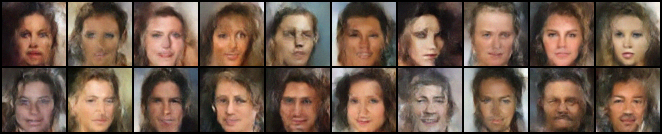

In [227]:
from IPython import display
display.Image("sample/021901.png", width=1000)

# Experiments

## Setup 1
Let's just drop some of the 3 main parts? And see how each of them affect the result.

We also will be able to see how each of the parts influences the convergence speed (*we don't take into account the number of parameters the point is in the influence*)

In [204]:
for n in range(1, 8):
    # layers_mask = [use_act_norm, use_one_conv, use_coupling]
    mask = [(n // 2 ** i) % 2 for i in range(3)][::-1]
    print(mask)
    CONFIG.layers_mask = mask
    model, optimizer = make_model(CONFIG)
    model_prefix = "m" + "".join([str(m) for m in mask])
    loss_hist = train(CONFIG, model, optimizer, train_loader, model_prefix=model_prefix)
    save_all(model, optimizer, CONFIG, loss_hist, model_prefix=model_prefix)

[1, 0, 0]


Loss: 0.91103; logP: 0.12153; logdet: 1.96743;: 100%|█████████████████████████████████| 10/10 [22:21<00:00, 134.17s/it]


[1, 0, 1]


Loss: 0.58082; logP: -0.00031; logdet: 2.41949;: 100%|████████████████████████████████| 10/10 [38:41<00:00, 232.15s/it]


[1, 1, 0]


Loss: -0.14448; logP: -0.05810; logdet: 3.20259;: 100%|███████████████████████████████| 10/10 [23:49<00:00, 142.91s/it]


[1, 1, 1]


Loss: -0.50842; logP: 0.05521; logdet: 3.45321;: 100%|████████████████████████████████| 10/10 [37:35<00:00, 225.53s/it]


Let's draw the resulting losses

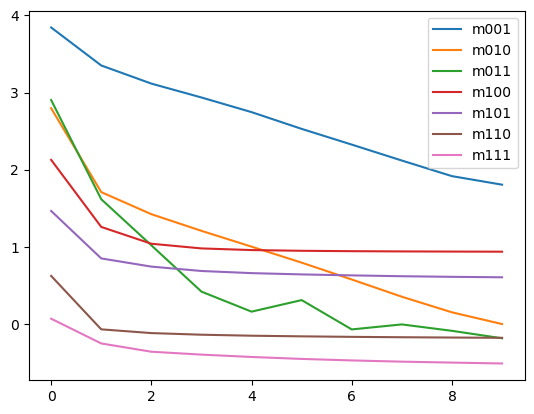

In [206]:
for n in range(1, 8):
    # layers_mask = [use_act_norm, use_one_conv, use_coupling]
    mask = [(n // 2 ** i) % 2 for i in range(3)][::-1]
    model_prefix = "m" + "".join([str(m) for m in mask])
    with open(f"checkpoints/losss_{model_prefix}.json", "r") as f:
        losses = json.load(f)
    plt.plot(losses['Loss'], label=model_prefix)
plt.legend()
plt.show()

Losses obtained by removing only one part of the flow

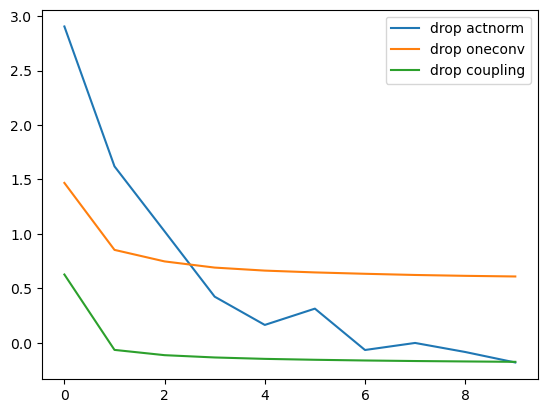

In [229]:
for i, name in zip(range(3), 
             ['drop actnorm', 'drop oneconv', 'drop coupling']):
    # layers_mask = [use_act_norm, use_one_conv, use_coupling]
    mask = [1]*3
    mask[i] = 0
    model_prefix = "m" + "".join([str(m) for m in mask])
    with open(f"checkpoints/losss_{model_prefix}.json", "r") as f:
        losses = json.load(f)
    plt.plot(losses['Loss'], label=name)
plt.legend()
plt.show()

`quick result`: fun fact, even though the part with one-convolution contains less parameters, it's essential to achieve good quality

### Setup 2

In [230]:
# TODO:
# Try replace affine coupling with checkerboard
# Try to drop the convolution, but increase the number of parameters